<h1> Evaluate Training Process and Submit Test Predictions </h1>

In [9]:
import numpy as np
np.set_printoptions(suppress=True) # no exponential print
import pandas as pd
pd.set_option('max_columns', 300)
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
%matplotlib inline
import cv2
import os, sys, time
from multiprocessing import cpu_count
# sklearn:
from scipy.optimize import curve_fit
from sklearn.metrics import accuracy_score, f1_score

In [10]:
RUN_NAME  = '04.01.19_2' ######################################## UPDATE THIS ########################################
BEST_NAME = '04.01.19_1'

LABELS_DIR = "D:\\OneDrive - studium.uni-hamburg.de\\Programmierung\\Python\\Kaggle\\GalaxyZoo\\"
TRAIN_DIR  = "C:\\ML-Datasets\\\GalaxyZoo\\train\\"
TEST_DIR   = "C:\\ML-Datasets\\\GalaxyZoo\\test\\"

NET_FOLDER   = 'MyNet\\'
IMG_SIZE     = (224, 224)
DATA_TYPE = ".jpg"
    
WEIGHTS_DIR = LABELS_DIR + 'results_and_weights\\' + NET_FOLDER

<h2> Loss and Accuracy plotted over Epoch </h2>

In [11]:
# Load training log
train_hist_curr = np.load(WEIGHTS_DIR + RUN_NAME  + '\\' + "training_log.npy")
train_hist_best = np.load(WEIGHTS_DIR + BEST_NAME + '\\' + "training_log.npy") # currently the best run for comparison

loss, val_loss, acc, val_acc, f1_score, val_f1_score = [train_hist_curr.item()[item] for item in ['loss', 'val_loss', 'acc', 'val_acc', 'f1_score', 'val_f1_score']]
loss_best, val_loss_best, acc_best, val_acc_best, f1_score_best, val_f1_score_best = [train_hist_best.item()[item] for item in ['loss', 'val_loss', 'acc', 'val_acc', 'f1_score', 'val_f1_score']] 

Compare current run with best run:
Check if runs had the same loss function and was trained only on one target images or on all images
min val_loss      0.009774602982286665 at Epoch 91
min val_loss_best 0.011917536359276719 at Epoch 63


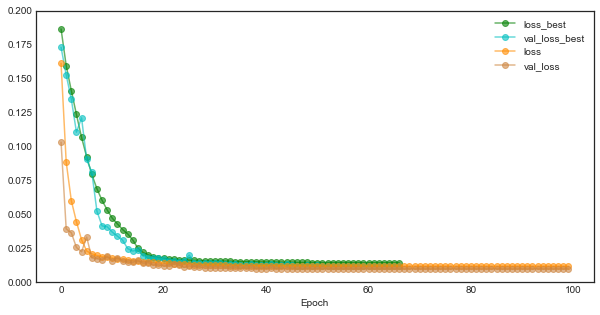

In [12]:
print("Compare current run with best run:")
print("Check if runs had the same loss function and was trained only on one target images or on all images")
print("min val_loss     ", np.min(val_loss), "at Epoch", np.argmin(val_loss))
print("min val_loss_best", np.min(val_loss_best), "at Epoch", np.argmin(val_loss_best))
plt.figure(figsize=(10,5))
plt.plot(list(range(len(loss_best))),     loss_best, 'o-', color="g",label='loss_best', alpha=0.6)
plt.plot(list(range(len(val_loss_best))), val_loss_best, 'o-', color="c",label='val_loss_best', alpha=0.6)
plt.plot(list(range(len(loss))),     loss,'-o', color="darkorange", label='loss', alpha=0.6)
plt.plot(list(range(len(val_loss))), val_loss,'-o', color="peru",label='val_loss', alpha=0.6)
plt.xlabel("Epoch")
plt.ylim(0,0.2)
plt.legend()
plt.show()

max val_acc 0.8054563170053929
max val_acc_best 0.7689184800453409


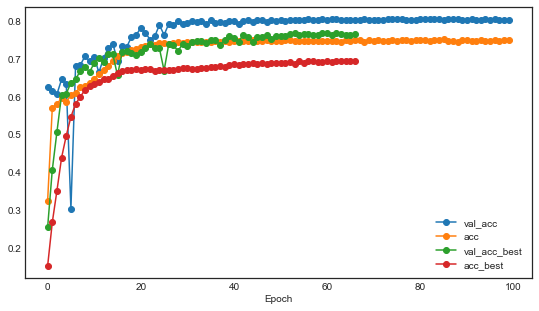

In [13]:
print("max val_acc", np.max(val_acc))
print("max val_acc_best", np.max(val_acc_best))

plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plt.plot(list(range(len(val_acc))), val_acc,'-o', label='val_acc')
plt.plot(list(range(len(acc))), acc,'-o', label='acc')
plt.plot(list(range(len(val_acc_best))), val_acc_best,'-o', label='val_acc_best')
plt.plot(list(range(len(acc_best))), acc_best,'-o', label='acc_best')
plt.xlabel("Epoch")
plt.legend()

plt.show()

<h2> Predict Test Data for Submission to Kaggle </h2>

In [15]:
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, models
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, BatchNormalization
from keras.optimizers import Adam
from keras.initializers import Orthogonal
from keras.layers.advanced_activations import LeakyReLU

labels = pd.read_csv(LABELS_DIR + "training_solutions_rev1.csv") # just for the shape and column names

In [16]:
test_IDs = [int(x.rpartition('.')[0]) for x in os.listdir(TEST_DIR)]

test_gen  = ImageDataGenerator(rescale     = 1./255,
                               fill_mode   = 'reflect',
                               data_format = 'channels_last')
# test data
test_generator = test_gen.flow_from_directory(directory = TEST_DIR, 
                                              class_mode  = 'sparse',
                                              target_size = IMG_SIZE,
                                              color_mode  = 'rgb',
                                              batch_size  = 128,
                                              shuffle     = False)
test_generator.filenames   = np.array([str(img_id)+DATA_TYPE for img_id in test_IDs])
test_generator.classes     = np.zeros((len(test_IDs), 37))
test_generator.samples     = len(test_IDs)
test_generator.n           = len(test_IDs)

print("Ignore prints above. The generator(s) got setup correctly.")

Found 0 images belonging to 0 classes.
Ignore prints above. The generator(s) got setup correctly.


In [24]:
img_shape       = (IMG_SIZE[0], IMG_SIZE[1], 3)
img_in          = layers.Input(img_shape, name='RGB-In')

orthogonal_init = Orthogonal(gain=1.0, seed=43)
'''  CNN-Layers   ''' 
# AlexNet (changed strides first layer 4->3)
conv_1          = BatchNormalization()(MaxPooling2D(pool_size=(3, 3))(Conv2D(96, (6,6), strides=2, activation = 'relu', kernel_initializer=orthogonal_init, padding='same')(img_in)))
conv_2          = BatchNormalization()(MaxPooling2D(pool_size=(3, 3), strides=2)(Conv2D(256, (3,3),  activation = 'relu', kernel_initializer=orthogonal_init, padding='same')(conv_1)))
conv_3          = BatchNormalization()(Conv2D(384, (3,3), activation = 'relu', kernel_initializer=orthogonal_init, padding='same')(conv_2))
conv_4          = BatchNormalization()(Conv2D(384, (3,3), activation = 'relu', kernel_initializer=orthogonal_init, padding='same')(conv_3))
conv_5          = BatchNormalization()(MaxPooling2D(pool_size=(3, 3), strides=2)(Conv2D(256, (3,3),  activation = 'relu', kernel_initializer=orthogonal_init, padding='same')(conv_4)))
flatten         = Flatten()(conv_5)

'''   Dense Layers   '''
dense_1         = Dense(128, kernel_initializer=orthogonal_init, activation = 'relu')(flatten) # , activation = 'relu'
# activation_1    = LeakyReLU(alpha=.01)(dense_1)
dropout_1        = Dropout(0.4)(dense_1)
bn_6            = BatchNormalization()(dropout_1)

dense_2         = Dense(50, kernel_initializer=orthogonal_init, activation = 'linear')(bn_6) # , activation = 'relu'
activation_2    = LeakyReLU(alpha=.01)(dense_2)
dropout_2       = Dropout(0.4)(activation_2)
bn_7            = BatchNormalization()(dropout_2)

out_layer       = Dense(labels.shape[1]-1, activation = 'sigmoid')(bn_7) # 37 classes

'''   Define and compile Model   '''
galaxy_model   = models.Model(inputs = [img_in], outputs = [out_layer], name = 'galaxy_model')
galaxy_model.compile(loss      = 'mean_squared_error',
                      optimizer = Adam(lr=1e-5),
                      metrics   = ['acc', 'binary_crossentropy'])
galaxy_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RGB-In (InputLayer)          (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 112, 112, 96)      10464     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 37, 37, 96)        0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 37, 37, 96)        384       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 37, 37, 256)       221440    
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 18, 18, 256)       0         
_________________________________________________________________
batch_normalization_28 (Batc (None, 18, 18, 256)       1024      
__________

In [25]:
galaxy_model.load_weights(WEIGHTS_DIR + RUN_NAME + '\\best.weights.hdf5')

In [26]:
t0 = time.time()
test_generator.reset()
predicted_test = galaxy_model.predict_generator(test_generator, workers=cpu_count(), use_multiprocessing=False, verbose=1)
# np.save(WEIGHTS_DIR + RUN_NAME + '\\' + "test_predictions", predicted_test) # get saved below as csv
print(np.round(time.time()-t0, 2),"s") # ~80s

625/625 [==============================] - 81s 129ms/step
80.96 s


In [27]:
submission = pd.DataFrame(predicted_test, columns=labels.columns.values[1:])
submission.insert(0, 'GalaxyID', test_IDs)
submission.head()

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,Class5.1,Class5.2,Class5.3,Class5.4,Class6.1,Class6.2,Class7.1,Class7.2,Class7.3,Class8.1,Class8.2,Class8.3,Class8.4,Class8.5,Class8.6,Class8.7,Class9.1,Class9.2,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100018,0.387885,0.601414,0.024693,0.104442,0.518728,0.138393,0.405501,0.245445,0.303703,0.050673,0.239904,0.237411,0.043449,0.214783,0.784572,0.102933,0.258385,0.087883,0.053179,0.009528,0.036669,0.049618,0.067196,0.044228,0.001215,0.078608,0.009274,0.039519,0.125219,0.100370,0.044491,0.017482,0.101302,0.017367,0.003716,0.003290,0.119412
1,100037,0.377257,0.605967,0.021674,0.287966,0.277485,0.058013,0.224332,0.077310,0.186283,0.040223,0.124145,0.094234,0.020180,0.163061,0.838304,0.032466,0.104395,0.189025,0.014055,0.009382,0.032271,0.033471,0.057426,0.027331,0.001407,0.151234,0.021349,0.113677,0.032431,0.025986,0.022907,0.009609,0.032520,0.007953,0.002573,0.002770,0.052434
2,100042,0.449369,0.528660,0.023880,0.232809,0.230839,0.037952,0.186006,0.047115,0.174675,0.033204,0.091977,0.081029,0.019076,0.133437,0.867818,0.035734,0.153621,0.186303,0.009101,0.008860,0.027673,0.025700,0.051208,0.021611,0.001119,0.122189,0.016402,0.087094,0.021052,0.014990,0.014352,0.006544,0.017048,0.005210,0.001892,0.002115,0.039099
3,100052,0.443225,0.540962,0.028570,0.069488,0.482546,0.130451,0.398485,0.211564,0.312920,0.033603,0.216789,0.254294,0.045461,0.200052,0.799664,0.238906,0.208959,0.059162,0.051622,0.008035,0.033298,0.037669,0.067697,0.039352,0.000915,0.048968,0.006184,0.030772,0.111273,0.083885,0.032362,0.014937,0.080804,0.014366,0.002274,0.002515,0.106084
4,100056,0.301950,0.685563,0.012990,0.388408,0.256002,0.053268,0.207229,0.084657,0.146723,0.039161,0.125971,0.070082,0.013542,0.155289,0.845923,0.011065,0.053553,0.179152,0.009614,0.006060,0.029454,0.031519,0.047580,0.021683,0.000970,0.186816,0.024515,0.134099,0.029783,0.025864,0.023233,0.007588,0.035305,0.007227,0.002174,0.002150,0.047553


In [28]:
submission.to_csv(WEIGHTS_DIR + RUN_NAME + '\\submission.csv', index=False)
submission.shape

(79975, 38)

Best result so far (run 04.01.19_1): <b>0.11013</b> mean squared loss on kaggle -> <b>Rank 76/326</b>

Best result from other Kagglers: 0.0749 msl

All zeros benchmark: 0.27210 msl

Central pixel benchmark: 0.16234 msl